This is a simple example using Transfer Learning for an image recognition problem.

# Imports de Libs

In [1]:
# General Libs
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Lendo o dataset

In [2]:
# Alguns parâmetros para leitura do dataset
im_shape = (299,299)

TRAINING_DIR = 'jeruk/train'
TEST_DIR = 'jeruk/test'

seed = 10

BATCH_SIZE = 16

In [7]:
#Using keras ImageGenerator and flow_from_directoty

# Image dataset without augmentation
#data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
# With augmentation
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [8]:

# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 933 images belonging to 4 classes.
Found 231 images belonging to 4 classes.
Found 626 images belonging to 4 classes.
Classes: ['blackspot', 'canker', 'fresh', 'grenning']


In [19]:
# # Visualisasikan beberapa contoh dataset oleh Generator yang dibuat
# plt.figure(figsize=(15,15))
# for i in range(9):
#     #gera subfigures
#     plt.subplot(330 + 1 + i)aa
#     batch = (train_generator.next()[0]+1)/2*255
#     image = batch[0].astype('uint8')
#     plt.imshow(image)
# plt.show()

# ERRORS

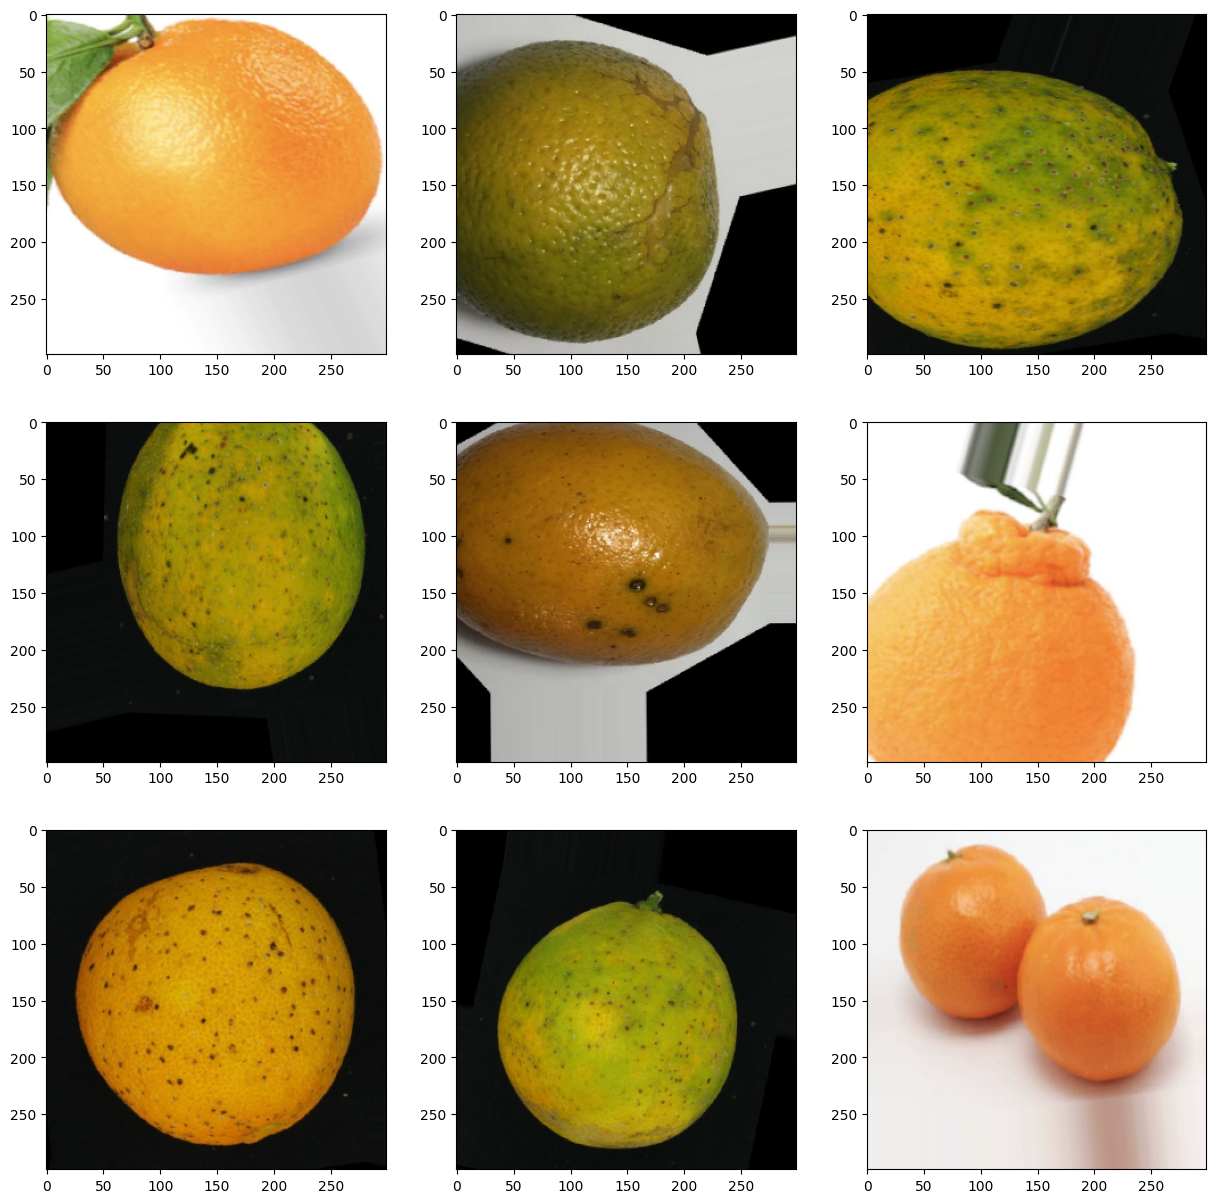

In [10]:
import matplotlib.pyplot as plt

# Visualizing some examples from the dataset using the created Generator
plt.figure(figsize=(15,15))
for i in range(9):
    # Generate subfigures
    plt.subplot(330 + 1 + i)
    batch = (next(train_generator)[0] + 1) / 2 * 255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()


# Transfer Learning from a Deep Model

In [17]:
base_model = InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
base_model.trainable = False

optimizer = Adam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
epochs = 20

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.NASnet.keras',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6640 - loss: 1.6110
Epoch 1: val_loss improved from inf to 0.12645, saving model to model.NASnet.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - accuracy: 0.6664 - loss: 1.5960 - val_accuracy: 0.9688 - val_loss: 0.1265
Epoch 2/20
 1/58 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.8125 - loss: 0.5406
Epoch 2: val_loss improved from 0.12645 to 0.01010, saving model to model.NASnet.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.8125 - loss: 0.5406 - val_accuracy: 1.0000 - val_loss: 0.0101
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9294 - loss: 0.1620
Epoch 3: val_loss did not improve from 0.01010
58/58 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.9297 - loss: 0.1616 - val_accuracy: 0.8839 - val_loss: 0.2319
Epoch 4/20
 1/58 ━━━━━━━━━━━━━━━━━━━━ 2:32 3s/step - accuracy: 0.8125 - loss: 0.2292
Epoch 4: val_loss improved from 0.01010 to 0.00024, saving model to model.NASnet.keras
58/58 ━━━━━━

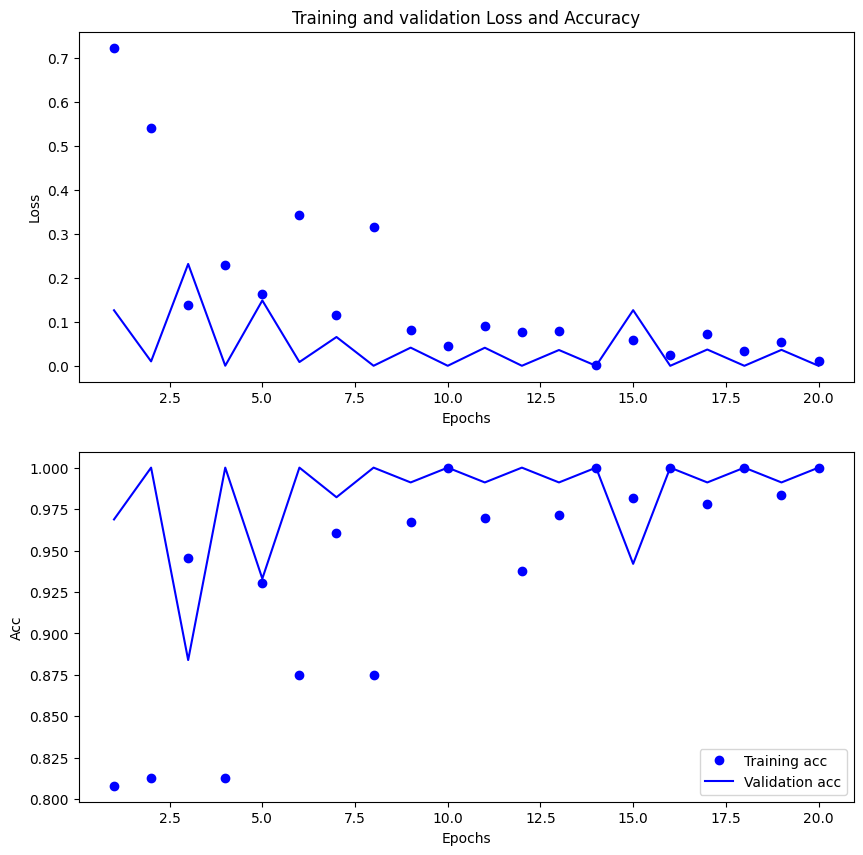

In [20]:
#Vamos ver como foi o treino?
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [22]:
from tensorflow.keras.models import load_model
# Load the best saved model
model = load_model('model.NASnet.keras')

In [23]:
#model.summary()

In [31]:
# Using the validation dataset
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9012 - loss: 0.2200
Val loss: 0.10407417267560959
Val accuracy: 0.9523809552192688


In [32]:
# Using the test dataset
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8876 - loss: 0.2697
Test loss: 0.11291074007749557
Test accuracy: 0.9536741375923157


In [33]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

40/40 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step


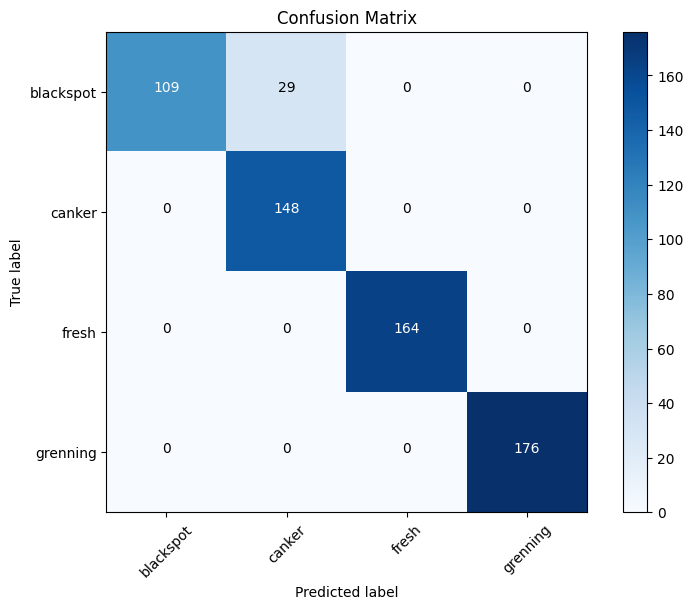

Classification Report
              precision    recall  f1-score   support

   blackspot       1.00      0.79      0.88       138
      canker       0.84      1.00      0.91       148
       fresh       1.00      1.00      1.00       164
    grenning       1.00      1.00      1.00       176

    accuracy                           0.95       626
   macro avg       0.96      0.95      0.95       626
weighted avg       0.96      0.95      0.95       626

Cohen's Kappa Score: 0.9379914334314777


In [46]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import numpy as np

# Confusion Matrix and Classification Report
Y_pred = model.predict(test_generator)  # Use predict instead of predict_generator
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes  # Assuming 'classes' is defined elsewhere in your code

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Function to plot the confusion matrix (define it if not already defined)
def plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    import itertools
    import matplotlib.pyplot as plt

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# Cohen's Kappa Score
kappa_score = cohen_kappa_score(test_generator.classes, y_pred)
print('Cohen\'s Kappa Score:', kappa_score)


In [44]:
# # Some reports
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

# #Confution Matrix and Classification Report
# Y_pred = model.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
# y_pred = np.argmax(Y_pred, axis=1)
# target_names = classes

# #Confution Matrix
# cm = confusion_matrix(test_generator.classes, y_pred)
# plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
# print('Classification Report')
# print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# ERRORS